In [21]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno 

import re

In [2]:
originalDF = pd.read_excel('UT Completion and Sequencing.xlsx')

## Cleaning Data nan values

In [3]:
## Compl. Type has a couple nan values
originalDF['Compl. Type'] = originalDF['Compl. Type'].replace("No Data", np.nan).replace("unknown, probably hybrid", np.nan).replace("Not indicated",np.nan)



In [4]:
DatabaseDF = originalDF

## Using Missingno to visualize incomplete Data

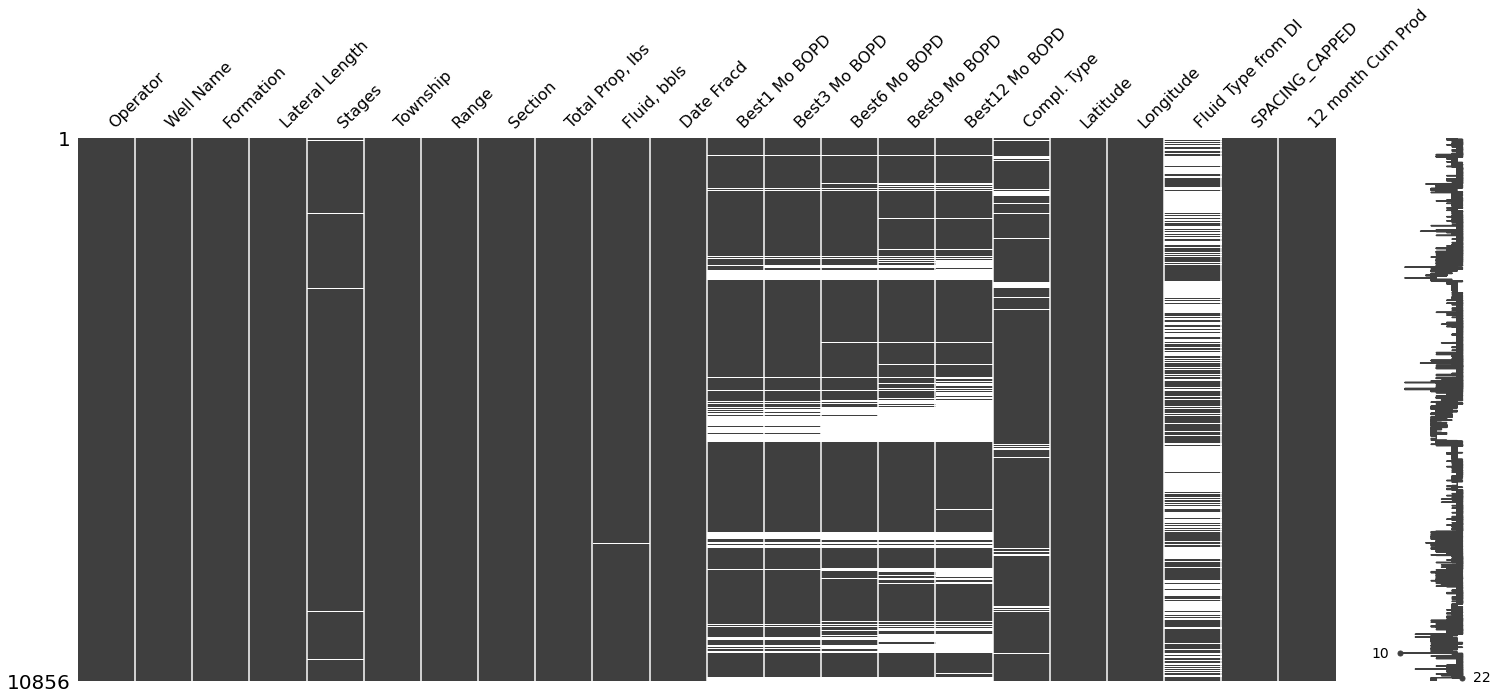

In [5]:
msno.matrix(DatabaseDF)

Our data appears to be relatively complete at first glace. The only variables that have noticibly many missing values are : Stages, Best# Mo BOPD, Compl. Type, and Fluid Type from DI.

It should be noted however that for Stages we are not sure if 0 should be interpreted as a NaN value

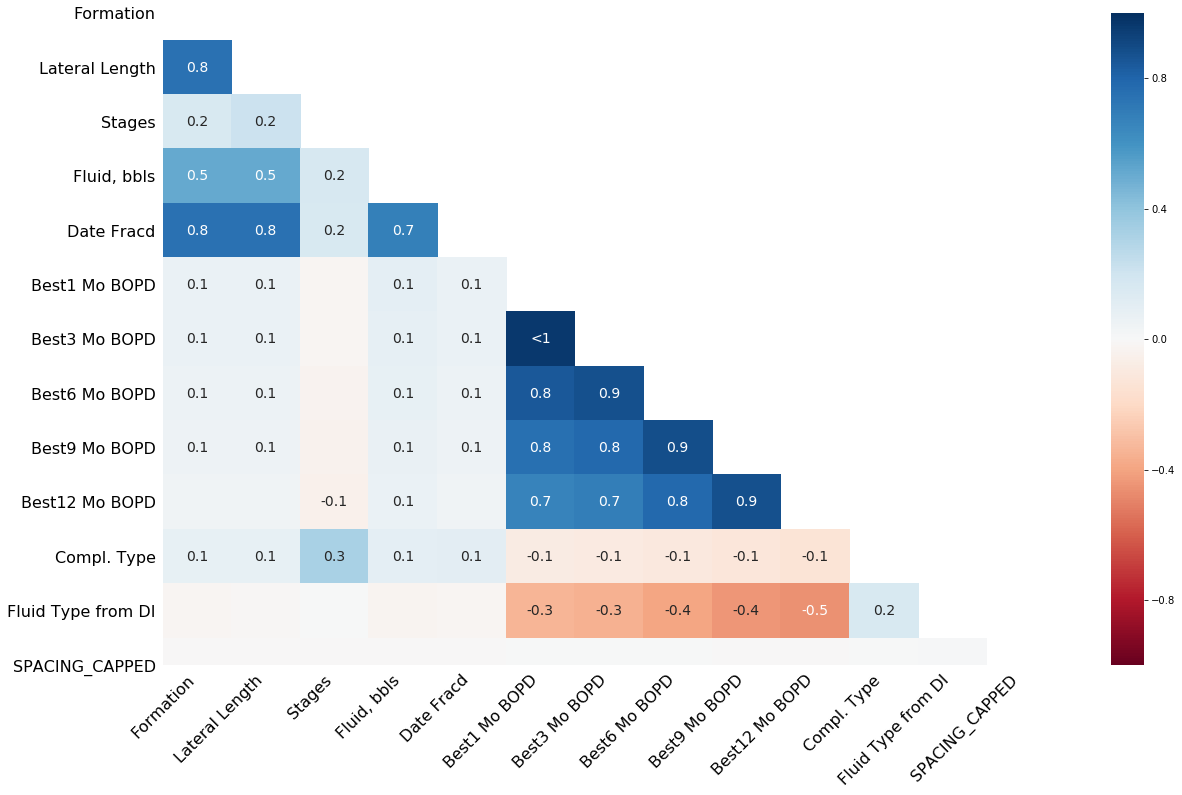

In [6]:
msno.heatmap(DatabaseDF)

I wasn't expecting this to give meaningfull information, since really we don't care why the data isn't present. It is interesting to note that higher Best# Mo BOPD does not allways gaurentee the existence of lower Month BOPD, which means that there are some interesting holes in our data.

That's kind of all that Missingno can do, if I'm being perfectly honest its not super usefull for us

## Variable comparabilities

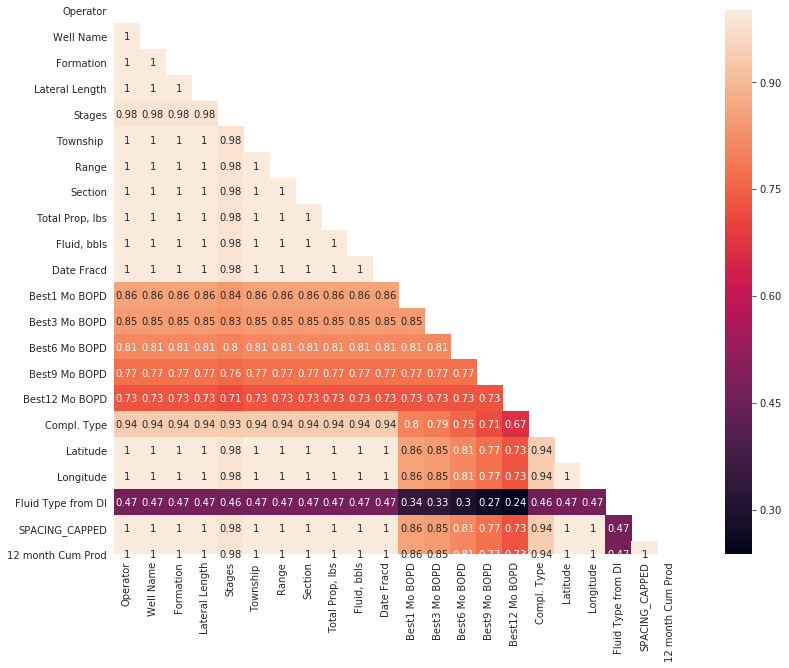

In [7]:
## 2 variable comparison 


colList = list(DatabaseDF.columns.values)
totalEntries = len(DatabaseDF)

Heatmap = []

for column in colList:
    rowList = []
    for row in colList:
        missing = len((DatabaseDF[(DatabaseDF[column].isna()) | DatabaseDF[row].isna()]))
        percentAvailable = 1 - (missing/totalEntries)
        rowList.append(percentAvailable)
    
    Heatmap.append(rowList)

mask = np.zeros_like(Heatmap)
mask[np.triu_indices_from(mask)] = True


heatmapDF = pd.DataFrame(Heatmap, columns = colList, index = colList)

with sns.axes_style("white"):
    plt.subplots(figsize = (15,10))
    sns.heatmap(heatmapDF, annot = True, mask = mask, square = True)




This table shows us what percent of total entries have both values, which gives us an idea of what values we will be able to compare. For the most part most 2 value pairs are present within the entire dataset except for the best Mo production, those are the main soucre of error.

## Compl. Type Repurposing

In [8]:
def completionTypeParser(string, stages):
    if (string == "nan"): return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    if (stages == "nan"): stages = 0

    integers = list(map(int, re.findall(r'\d+',string)))
    
    integerCount = len(integers)

    typeString = ''
    typeCount = [np.nan] * 5

    if (integerCount == 0):
        ## need to determine if uncountable

        if "and" not in string:
            ## it is uncountable
            if "orts" in string: 
                typeString = "Frac Ports"
                typeCount[2] = stages
            elif "Sleeves" in string:
                typeString = "Sleeves"
                typeCount[0] = stages
            elif "&" in string:
                typeString = "P & P"
                typeCount[1] = stages
            elif "CT" in string:
                typeString = "CT"
                typeCount[4] = stages
            elif "Tubing" in string:
                typeString = "CT"
                typeCount[4] = stages
            else:
                typeString = string
        else:
            typeString = "Sleeves and P & P"

    elif (integerCount == 2):
        ## Determine which to set

        ## Need to determine if this is worth checking
        ##if (sum(integers) != stages):
            ##print(string , "     ", stages)
            ##raise Exception("Stages should equal sum of completions")

        if "&" in string:
            ##P&P type
            if "eeve" in string:
                typeString = "Sleeves and P & P"
                typeCount[0] = integers[0]
                typeCount[1] = integers[1]
            elif "eater" in string:
                typeString = "Repeater Ports and P & P"
                typeCount[3] = integers[0]
                typeCount[1] = integers[1]
            elif "ort" in string:
                typeString = "Frac Ports and P & P"
                typeCount[2] = integers[0]
                typeCount[1] = integers[1]
            else:
                typeString = "P & P and CT"
                typeCount[1] = integers[0]
                typeCount[4] = integers[1]
        else:
            ##not P&P type
            typeString = "Frac Ports and Repeater Ports"
            typeCount[2] = integers[0]
            typeCount[3] = integers[1]
    else:
        raise Exception("String should contain either two or no numbers")
    
    return typeString, typeCount[0], typeCount[1], typeCount[2], typeCount[3], typeCount[4]
    


In [9]:
completionTypeData = []

for index, row in DatabaseDF.iterrows():
    parseResults = completionTypeParser(str(row['Compl. Type']), row['Stages'])
    completionTypeData.append(parseResults);
    
completionTypeDF = pd.DataFrame(completionTypeData, columns= ["Completion Type", "Sleeves", "P&P", "Frac Ports", "Repeater Ports", "CT"])

DatabaseDF = DatabaseDF.join(completionTypeDF)

In [9]:
DatabaseDF.head()

,Operator,Well Name,Formation,Lateral Length,Stages,Township,Range,Section,"Total Prop, lbs","Fluid, bbls",...,Best3 Mo BOPD,Best6 Mo BOPD,Best9 Mo BOPD,Best12 Mo BOPD,Compl. Type,Latitude,Longitude,Fluid Type from DI,SPACING_CAPPED,12 month Cum Prod
0,Operator 1,Well 1,MBH,5114.0,30.0,141,99,10,0.0,16079.0,...,127.690116,110.009862,97.351888,88.275258,NaN,47.051150,-103.214580,NaN,660.0,33.55
1,Operator 2,Well 2,MBH,5181.0,NaN,142,99,16,418000.0,7269.0,...,127.832566,99.128863,83.694938,72.019505,NaN,47.111368,-103.225059,NaN,660.0,27.62
2,Operator 2,Well 3,MBH,4780.0,15.0,142,99,24,568407.0,8279.0,...,44.334867,36.905545,31.766382,28.566732,OH,47.097032,-103.160910,NaN,660.0,11.19
3,Operator 1,Well 4,MBH,10654.0,1.0,142,99,1,845000.0,9342.0,...,120.764848,99.172693,86.675433,75.882095,NaN,47.140248,-103.178391,NaN,660.0,27.85
4,Operator 2,Well 5,MBH,5209.0,1.0,142,99,35,297366.0,4523.0,...,227.580539,189.869603,163.163854,140.033969,OH,47.080872,-103.181300,NaN,660.0,50.88


In [10]:
DatabaseDF.columns

Index(['Operator', 'Well Name', 'Formation', 'Lateral Length', 'Stages',
       'Township ', 'Range', 'Section', 'Total Prop, lbs', 'Fluid, bbls',
       'Date Fracd', 'Best1 Mo BOPD', 'Best3 Mo BOPD', 'Best6 Mo BOPD',
       'Best9 Mo BOPD', 'Best12 Mo BOPD', 'Compl. Type', 'Latitude',
       'Longitude', 'Fluid Type from DI', 'SPACING_CAPPED',
       '12 month Cum Prod'],
      dtype='object')

## Adding the Year the well was drilled

Adding a column recording the year from the date for potentially future clustering of the data based upon the year the well was drilled.

In [20]:
DatabaseDF["Date Fracd"]

0       2006-01-01
1       2005-01-01
2       2006-10-10
3       2007-01-01
4       2006-09-18
           ...    
10851   2016-03-27
10852   2015-09-03
10853   2015-09-03
10854   2015-08-25
10855   2015-11-05
Name: Date Fracd, Length: 10856, dtype: datetime64[ns]

In [33]:
DatabaseDF["Year Drilled"] = DatabaseDF["Date Fracd"].dt.year

0       2006-01-01
1       2005-01-01
2       2006-10-10
3       2007-01-01
4       2006-09-18
           ...    
10851   2016-03-27
10852   2015-09-03
10853   2015-09-03
10854   2015-08-25
10855   2015-11-05
Name: Date Fracd, Length: 10856, dtype: datetime64[ns]

In [34]:
DatabaseDF.head()

,Operator,Well Name,Formation,Lateral Length,Stages,Township,Range,Section,"Total Prop, lbs","Fluid, bbls",...,Best6 Mo BOPD,Best9 Mo BOPD,Best12 Mo BOPD,Compl. Type,Latitude,Longitude,Fluid Type from DI,SPACING_CAPPED,12 month Cum Prod,Year Drilled
0,Operator 1,Well 1,MBH,5114.0,30.0,141,99,10,0.0,16079.0,...,110.009862,97.351888,88.275258,NaN,47.051150,-103.214580,NaN,660.0,33.55,2006.0
1,Operator 2,Well 2,MBH,5181.0,NaN,142,99,16,418000.0,7269.0,...,99.128863,83.694938,72.019505,NaN,47.111368,-103.225059,NaN,660.0,27.62,2005.0
2,Operator 2,Well 3,MBH,4780.0,15.0,142,99,24,568407.0,8279.0,...,36.905545,31.766382,28.566732,OH,47.097032,-103.160910,NaN,660.0,11.19,2006.0
3,Operator 1,Well 4,MBH,10654.0,1.0,142,99,1,845000.0,9342.0,...,99.172693,86.675433,75.882095,NaN,47.140248,-103.178391,NaN,660.0,27.85,2007.0
4,Operator 2,Well 5,MBH,5209.0,1.0,142,99,35,297366.0,4523.0,...,189.869603,163.163854,140.033969,OH,47.080872,-103.181300,NaN,660.0,50.88,2006.0
